In [1]:
# download pre-trained model
!wget -O u2netp.pth https://drive.google.com/u/0/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy&export=download 
!wget -O u2netp.onnx https://drive.google.com/uc?id=1OPfir1PXZAABPEZpIppauGKDu8LYXoIm&authuser=0&export=download

--2021-07-28 20:21:09--  https://drive.google.com/u/0/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
Resolving drive.google.com (drive.google.com)... 74.125.195.139, 74.125.195.102, 74.125.195.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2t0qn3btv3rge7qtl41s7h0nj4m6hugd/1627503600000/03577919667552571905/*/1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy [following]
--2021-07-28 20:21:09--  https://doc-00-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2t0qn3btv3rge7qtl41s7h0nj4m6hugd/1627503600000/03577919667552571905/*/1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
Resolving doc-00-78-docs.googleusercontent.com (doc-00-78-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-00-78-docs.googleusercontent.com (doc-00-78-docs.googleusercontent.com)|74

In [2]:
#u2netp
import torch
import torch.nn as nn
from torchvision import models
#import torch.nn.functional as F

In [3]:
class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

### RSU-7 ###
class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

#        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
# edit for onnx compatibility
        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6up = self.upscore2(hx6d)
        # print(hx6up.shape,hx5.shape)
        hx5d =  self.rebnconv5d(torch.cat((hx6up,hx5),1))
        hx5dup = self.upscore2(hx5d)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = self.upscore2(hx4d)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = self.upscore2(hx5d)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = self.upscore2(hx4d)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = self.upscore2(hx4d)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,1,3,padding=1)
        self.side2 = nn.Conv2d(64,1,3,padding=1)
        self.side3 = nn.Conv2d(128,1,3,padding=1)
        self.side4 = nn.Conv2d(256,1,3,padding=1)
        self.side5 = nn.Conv2d(512,1,3,padding=1)
        self.side6 = nn.Conv2d(512,1,3,padding=1)

        self.upscore6 = nn.Upsample(scale_factor=32,mode='bilinear',align_corners=True)
        self.upscore5 = nn.Upsample(scale_factor=16,mode='bilinear',align_corners=True)
        self.upscore4 = nn.Upsample(scale_factor=8,mode='bilinear',align_corners=True)
        self.upscore3 = nn.Upsample(scale_factor=4,mode='bilinear',align_corners=True)
        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)

        self.outconv = nn.Conv2d(6,1,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)



        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = self.upscore2(hx6)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = self.upscore2(hx5d)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = self.upscore2(hx4d)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = self.upscore2(d2)

        d3 = self.side3(hx3d)
        d3 = self.upscore3(d3)

        d4 = self.side4(hx4d)
        d4 = self.upscore4(d4)

        d5 = self.side5(hx5d)
        d5 = self.upscore5(d5)

        d6 = self.side6(hx6)
        d6 = self.upscore6(d6)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        F.sigmokd
        return torch.sigmoid(d0), torch.sigmoid(d1), torch.sigmoid(d2), torch.sigmoid(d3), torch.sigmoid(d4), torch.sigmoid(d5), torch.sigmoid(d6)

### U^2-Net small ###
class U2NETP(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NETP,self).__init__()

        self.stage1 = RSU7(in_ch,16,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,16,64)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(64,16,64)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(64,16,64)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(64,16,64)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(64,16,64)

        # decoder
        self.stage5d = RSU4F(128,16,64)
        self.stage4d = RSU4(128,16,64)
        self.stage3d = RSU5(128,16,64)
        self.stage2d = RSU6(128,16,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,1,3,padding=1)
        self.side2 = nn.Conv2d(64,1,3,padding=1)
        self.side3 = nn.Conv2d(64,1,3,padding=1)
        self.side4 = nn.Conv2d(64,1,3,padding=1)
        self.side5 = nn.Conv2d(64,1,3,padding=1)
        self.side6 = nn.Conv2d(64,1,3,padding=1)

        self.upscore6 = nn.Upsample(scale_factor=32,mode='bilinear',align_corners=True)
        self.upscore5 = nn.Upsample(scale_factor=16,mode='bilinear',align_corners=True)
        self.upscore4 = nn.Upsample(scale_factor=8,mode='bilinear',align_corners=True)
        self.upscore3 = nn.Upsample(scale_factor=4,mode='bilinear',align_corners=True)
        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)

        self.outconv = nn.Conv2d(6,1,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = self.upscore2(hx6)

        #decoder
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = self.upscore2(hx5d)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = self.upscore2(hx4d)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = self.upscore2(d2)

        d3 = self.side3(hx3d)
        d3 = self.upscore3(d3)

        d4 = self.side4(hx4d)
        d4 = self.upscore4(d4)

        d5 = self.side5(hx5d)
        d5 = self.upscore5(d5)

        d6 = self.side6(hx6)
        d6 = self.upscore6(d6)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))
        # d00 = d0 + self.refconv(d0)

        return torch.sigmoid(d0), torch.sigmoid(d1), torch.sigmoid(d2), torch.sigmoid(d3), torch.sigmoid(d4), torch.sigmoid(d5), torch.sigmoid(d6)

In [4]:
net = U2NETP(3,1)

In [5]:
# data loader
from __future__ import print_function, division
import glob
import torch
from skimage import io, transform, color
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
#==========================dataset load==========================
class RescaleT(object):

	def __init__(self,output_size):
		assert isinstance(output_size,(int,tuple))
		self.output_size = output_size

	def __call__(self,sample):
		imidx, image, label = sample['imidx'], sample['image'],sample['label']

		h, w = image.shape[:2]

		if isinstance(self.output_size,int):
			if h > w:
				new_h, new_w = self.output_size*h/w,self.output_size
			else:
				new_h, new_w = self.output_size,self.output_size*w/h
		else:
			new_h, new_w = self.output_size

		new_h, new_w = int(new_h), int(new_w)

		# #resize the image to new_h x new_w and convert image from range [0,255] to [0,1]
		# img = transform.resize(image,(new_h,new_w),mode='constant')
		# lbl = transform.resize(label,(new_h,new_w),mode='constant', order=0, preserve_range=True)

		img = transform.resize(image,(self.output_size,self.output_size),mode='constant')
		lbl = transform.resize(label,(self.output_size,self.output_size),mode='constant', order=0, preserve_range=True)

		return {'imidx':imidx, 'image':img,'label':lbl}

class Rescale(object):

	def __init__(self,output_size):
		assert isinstance(output_size,(int,tuple))
		self.output_size = output_size

	def __call__(self,sample):
		imidx, image, label = sample['imidx'], sample['image'],sample['label']

		h, w = image.shape[:2]

		if isinstance(self.output_size,int):
			if h > w:
				new_h, new_w = self.output_size*h/w,self.output_size
			else:
				new_h, new_w = self.output_size,self.output_size*w/h
		else:
			new_h, new_w = self.output_size

		new_h, new_w = int(new_h), int(new_w)

		# #resize the image to new_h x new_w and convert image from range [0,255] to [0,1]
		img = transform.resize(image,(new_h,new_w),mode='constant')
		lbl = transform.resize(label,(new_h,new_w),mode='constant', order=0, preserve_range=True)

		return {'imidx':imidx, 'image':img,'label':lbl}

class RandomCrop(object):

	def __init__(self,output_size):
		assert isinstance(output_size, (int, tuple))
		if isinstance(output_size, int):
			self.output_size = (output_size, output_size)
		else:
			assert len(output_size) == 2
			self.output_size = output_size
	def __call__(self,sample):
		imidx, image, label = sample['imidx'], sample['image'], sample['label']

		h, w = image.shape[:2]
		new_h, new_w = self.output_size

		top = np.random.randint(0, h - new_h)
		left = np.random.randint(0, w - new_w)

		image = image[top: top + new_h, left: left + new_w]
		label = label[top: top + new_h, left: left + new_w]

		return {'imidx':imidx,'image':image, 'label':label}

class ToTensor(object):
	"""Convert ndarrays in sample to Tensors."""

	def __call__(self, sample):

		imidx, image, label = sample['imidx'], sample['image'], sample['label']

		tmpImg = np.zeros((image.shape[0],image.shape[1],3))
		tmpLbl = np.zeros(label.shape)

		image = image/np.max(image)
		if(np.max(label)<1e-6):
			label = label
		else:
			label = label/np.max(label)

		if image.shape[2]==1:
			tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
			tmpImg[:,:,1] = (image[:,:,0]-0.485)/0.229
			tmpImg[:,:,2] = (image[:,:,0]-0.485)/0.229
		else:
			tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
			tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224
			tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225

		tmpLbl[:,:,0] = label[:,:,0]

		# change the r,g,b to b,r,g from [0,255] to [0,1]
		#transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
		tmpImg = tmpImg.transpose((2, 0, 1))
		tmpLbl = label.transpose((2, 0, 1))

		return {'imidx':torch.from_numpy(imidx), 'image': torch.from_numpy(tmpImg), 'label': torch.from_numpy(tmpLbl)}

class ToTensorLab(object):
	"""Convert ndarrays in sample to Tensors."""
	def __init__(self,flag=0):
		self.flag = flag

	def __call__(self, sample):

		imidx, image, label =sample['imidx'], sample['image'], sample['label']

		tmpLbl = np.zeros(label.shape)

		if(np.max(label)<1e-6):
			label = label
		else:
			label = label/np.max(label)

		# change the color space
		if self.flag == 2: # with rgb and Lab colors
			tmpImg = np.zeros((image.shape[0],image.shape[1],6))
			tmpImgt = np.zeros((image.shape[0],image.shape[1],3))
			if image.shape[2]==1:
				tmpImgt[:,:,0] = image[:,:,0]
				tmpImgt[:,:,1] = image[:,:,0]
				tmpImgt[:,:,2] = image[:,:,0]
			else:
				tmpImgt = image
			tmpImgtl = color.rgb2lab(tmpImgt)

			# nomalize image to range [0,1]
			tmpImg[:,:,0] = (tmpImgt[:,:,0]-np.min(tmpImgt[:,:,0]))/(np.max(tmpImgt[:,:,0])-np.min(tmpImgt[:,:,0]))
			tmpImg[:,:,1] = (tmpImgt[:,:,1]-np.min(tmpImgt[:,:,1]))/(np.max(tmpImgt[:,:,1])-np.min(tmpImgt[:,:,1]))
			tmpImg[:,:,2] = (tmpImgt[:,:,2]-np.min(tmpImgt[:,:,2]))/(np.max(tmpImgt[:,:,2])-np.min(tmpImgt[:,:,2]))
			tmpImg[:,:,3] = (tmpImgtl[:,:,0]-np.min(tmpImgtl[:,:,0]))/(np.max(tmpImgtl[:,:,0])-np.min(tmpImgtl[:,:,0]))
			tmpImg[:,:,4] = (tmpImgtl[:,:,1]-np.min(tmpImgtl[:,:,1]))/(np.max(tmpImgtl[:,:,1])-np.min(tmpImgtl[:,:,1]))
			tmpImg[:,:,5] = (tmpImgtl[:,:,2]-np.min(tmpImgtl[:,:,2]))/(np.max(tmpImgtl[:,:,2])-np.min(tmpImgtl[:,:,2]))

			# tmpImg = tmpImg/(np.max(tmpImg)-np.min(tmpImg))

			tmpImg[:,:,0] = (tmpImg[:,:,0]-np.mean(tmpImg[:,:,0]))/np.std(tmpImg[:,:,0])
			tmpImg[:,:,1] = (tmpImg[:,:,1]-np.mean(tmpImg[:,:,1]))/np.std(tmpImg[:,:,1])
			tmpImg[:,:,2] = (tmpImg[:,:,2]-np.mean(tmpImg[:,:,2]))/np.std(tmpImg[:,:,2])
			tmpImg[:,:,3] = (tmpImg[:,:,3]-np.mean(tmpImg[:,:,3]))/np.std(tmpImg[:,:,3])
			tmpImg[:,:,4] = (tmpImg[:,:,4]-np.mean(tmpImg[:,:,4]))/np.std(tmpImg[:,:,4])
			tmpImg[:,:,5] = (tmpImg[:,:,5]-np.mean(tmpImg[:,:,5]))/np.std(tmpImg[:,:,5])

		elif self.flag == 1: #with Lab color
			tmpImg = np.zeros((image.shape[0],image.shape[1],3))

			if image.shape[2]==1:
				tmpImg[:,:,0] = image[:,:,0]
				tmpImg[:,:,1] = image[:,:,0]
				tmpImg[:,:,2] = image[:,:,0]
			else:
				tmpImg = image

			tmpImg = color.rgb2lab(tmpImg)

			# tmpImg = tmpImg/(np.max(tmpImg)-np.min(tmpImg))

			tmpImg[:,:,0] = (tmpImg[:,:,0]-np.min(tmpImg[:,:,0]))/(np.max(tmpImg[:,:,0])-np.min(tmpImg[:,:,0]))
			tmpImg[:,:,1] = (tmpImg[:,:,1]-np.min(tmpImg[:,:,1]))/(np.max(tmpImg[:,:,1])-np.min(tmpImg[:,:,1]))
			tmpImg[:,:,2] = (tmpImg[:,:,2]-np.min(tmpImg[:,:,2]))/(np.max(tmpImg[:,:,2])-np.min(tmpImg[:,:,2]))

			tmpImg[:,:,0] = (tmpImg[:,:,0]-np.mean(tmpImg[:,:,0]))/np.std(tmpImg[:,:,0])
			tmpImg[:,:,1] = (tmpImg[:,:,1]-np.mean(tmpImg[:,:,1]))/np.std(tmpImg[:,:,1])
			tmpImg[:,:,2] = (tmpImg[:,:,2]-np.mean(tmpImg[:,:,2]))/np.std(tmpImg[:,:,2])

		else: # with rgb color
			tmpImg = np.zeros((image.shape[0],image.shape[1],3))
			image = image/np.max(image)
			if image.shape[2]==1:
				tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
				tmpImg[:,:,1] = (image[:,:,0]-0.485)/0.229
				tmpImg[:,:,2] = (image[:,:,0]-0.485)/0.229
			else:
				tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
				tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224
				tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225

		tmpLbl[:,:,0] = label[:,:,0]

		# change the r,g,b to b,r,g from [0,255] to [0,1]
		#transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
		tmpImg = tmpImg.transpose((2, 0, 1))
		tmpLbl = label.transpose((2, 0, 1))

		return {'imidx':torch.from_numpy(imidx), 'image': torch.from_numpy(tmpImg), 'label': torch.from_numpy(tmpLbl)}

class SalObjDataset(Dataset):
	def __init__(self,img_name_list,lbl_name_list,transform=None):
		# self.root_dir = root_dir
		# self.image_name_list = glob.glob(image_dir+'*.png')
		# self.label_name_list = glob.glob(label_dir+'*.png')
		self.image_name_list = img_name_list
		self.label_name_list = lbl_name_list
		self.transform = transform

	def __len__(self):
		return len(self.image_name_list)

	def __getitem__(self,idx):

		# image = Image.open(self.image_name_list[idx])#io.imread(self.image_name_list[idx])
		# label = Image.open(self.label_name_list[idx])#io.imread(self.label_name_list[idx])

		image = io.imread(self.image_name_list[idx])
		imname = self.image_name_list[idx]
		imidx = np.array([idx])

		if(0==len(self.label_name_list)):
			label_3 = np.zeros(image.shape)
		else:
			label_3 = io.imread(self.label_name_list[idx])

		label = np.zeros(label_3.shape[0:2])
		if(3==len(label_3.shape)):
			label = label_3[:,:,0]
		elif(2==len(label_3.shape)):
			label = label_3

		if(3==len(image.shape) and 2==len(label.shape)):
			label = label[:,:,np.newaxis]
		elif(2==len(image.shape) and 2==len(label.shape)):
			image = image[:,:,np.newaxis]
			label = label[:,:,np.newaxis]

		sample = {'imidx':imidx, 'image':image, 'label':label}

		if self.transform:
			sample = self.transform(sample)

		return sample

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/kaggle'

In [8]:
%cd /content/drive/My\ Drive/kaggle

/content/drive/My Drive/kaggle


In [10]:
!kaggle datasets download -d richardbarana/ep3-usp

 97% 233M/241M [00:01<00:00, 150MB/s]
100% 241M/241M [00:01<00:00, 139MB/s]


In [11]:
!ls

ep3-usp.zip  kaggle.json


In [12]:
!unzip \*.zip && rm *.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: augmentedDataset/caneta_3_dia_dentro_pano_3_conv.jpg  
  inflating: augmentedDataset/caneta_3_dia_dentro_pano_3_gamma.jpg  
  inflating: augmentedDataset/caneta_3_dia_dentro_pano_3_gradient.jpg  
  inflating: augmentedDataset/caneta_3_dia_dentro_pano_3_gray.jpg  
  inflating: augmentedDataset/caneta_3_dia_dentro_pano_3_log.jpg  
  inflating: augmentedDataset/caneta_3_dia_fora_madeira_1_conv.jpg  
  inflating: augmentedDataset/caneta_3_dia_fora_madeira_1_gamma.jpg  
  inflating: augmentedDataset/caneta_3_dia_fora_madeira_1_gradient.jpg  
  inflating: augmentedDataset/caneta_3_dia_fora_madeira_1_gray.jpg  
  inflating: augmentedDataset/caneta_3_dia_fora_madeira_1_log.jpg  
  inflating: augmentedDataset/caneta_3_dia_fora_madeira_2_conv.jpg  
  inflating: augmentedDataset/caneta_3_dia_fora_madeira_2_gamma.jpg  
  inflating: augmentedDataset/caneta_3_dia_fora_madeira_2_gradient.jpg  
  inflating: augmentedDataset/caneta

In [ ]:
# load test image
!wget https://github.com/NathanUA/U-2-Net/raw/master/test_data/test_images/sailboat3.jpg

--2021-03-02 16:23:03--  https://github.com/NathanUA/U-2-Net/raw/master/test_data/test_images/sailboat3.jpg
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/xuebinqin/U-2-Net/raw/master/test_data/test_images/sailboat3.jpg [following]
--2021-03-02 16:23:03--  https://github.com/xuebinqin/U-2-Net/raw/master/test_data/test_images/sailboat3.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xuebinqin/U-2-Net/master/test_data/test_images/sailboat3.jpg [following]
--2021-03-02 16:23:04--  https://raw.githubusercontent.com/xuebinqin/U-2-Net/master/test_data/test_images/sailboat3.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com

In [16]:
%cd /content/

/content


In [17]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils

model_dir = './u2netp.pth'
net.load_state_dict(torch.load(model_dir))
if torch.cuda.is_available():
  print("cuda is available")
  net.cuda()

torch.cuda.is_available()

cuda is available


True

In [18]:
import torch
import torch.onnx

# Create the right input shape (e.g. for an image)
dummy_input = torch.randn(1, 3, 320, 320).cuda()

torch.onnx.export(net, dummy_input, "onnx_u2netp.onnx", opset_version=11)
# UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9.
# This operator might cause results to not match the expected results by PyTorch.
# ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11.
# Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior 
# (like coordinate_transformation_mode and nearest_mode).
# We recommend using opset 11 and above for models using this operator. 
#   "" + str(_export_onnx_opset_version) + ". "
# /usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:182: UserWarning: ONNX export failed on upsample_bilinear2d because align_corners == True not supported
#   warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [19]:
%cd /content/drive/My\ Drive/kaggle/augmentedDataset/

/content/drive/My Drive/kaggle/augmentedDataset


In [20]:
img_name_list = glob.glob('./*.jpg')
img_name_list

['./caneta_1_dia_dentro_madeira_1_conv.jpg',
 './caneta_1_dia_dentro_madeira_1_gamma.jpg',
 './caneta_1_dia_dentro_madeira_1_gradient.jpg',
 './caneta_1_dia_dentro_madeira_1_gray.jpg',
 './caneta_1_dia_dentro_madeira_1_log.jpg',
 './caneta_1_dia_dentro_madeira_2_conv.jpg',
 './caneta_1_dia_dentro_madeira_2_gamma.jpg',
 './caneta_1_dia_dentro_madeira_2_gradient.jpg',
 './caneta_1_dia_dentro_madeira_2_gray.jpg',
 './caneta_1_dia_dentro_madeira_2_log.jpg',
 './caneta_1_dia_dentro_madeira_3_conv.jpg',
 './caneta_1_dia_dentro_madeira_3_gamma.jpg',
 './caneta_1_dia_dentro_madeira_3_gradient.jpg',
 './caneta_1_dia_dentro_madeira_3_gray.jpg',
 './caneta_1_dia_dentro_madeira_3_log.jpg',
 './caneta_1_dia_dentro_palha_1_conv.jpg',
 './caneta_1_dia_dentro_palha_1_gamma.jpg',
 './caneta_1_dia_dentro_palha_1_gradient.jpg',
 './caneta_1_dia_dentro_palha_1_gray.jpg',
 './caneta_1_dia_dentro_palha_1_log.jpg',
 './caneta_1_dia_dentro_palha_2_conv.jpg',
 './caneta_1_dia_dentro_palha_2_gamma.jpg',
 './can

In [21]:
net.eval()

U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(16, 16, 

In [22]:
test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                    lbl_name_list = [],
                                    transform=transforms.Compose([RescaleT(320),
                                                                  ToTensorLab(flag=0)])
                                    )
test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                    batch_size=1,
                                    shuffle=False,
                                    num_workers=1)

In [23]:
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

def genImage(image_name,pred):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split("/")[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)

    pb_np = np.array(imo)

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]

    return imo

# test_salobj_dataloader 에서 i_test랑 data_test를 어떻게 뽑아내지?
for i_test, data_test in enumerate(test_salobj_dataloader):
    print("inferencing:",img_name_list[i_test].split("/")[-1])
    inputs_test = data_test['image']
    inputs_test = inputs_test.type(torch.FloatTensor)
    inputs_test = Variable(inputs_test.cuda())
    # inputs_test = Variable(inputs_test)
    d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

    pred = d1[:,0,:,:]
    pred = normPRED(pred)


A saída de streaming foi truncada nas últimas 5000 linhas.
inferencing: caneta_3_dia_dentro_pano_3_conv.jpg
inferencing: caneta_3_dia_dentro_pano_3_gamma.jpg
inferencing: caneta_3_dia_dentro_pano_3_gradient.jpg
inferencing: caneta_3_dia_dentro_pano_3_gray.jpg
inferencing: caneta_3_dia_dentro_pano_3_log.jpg
inferencing: caneta_3_dia_fora_madeira_1_conv.jpg
inferencing: caneta_3_dia_fora_madeira_1_gamma.jpg
inferencing: caneta_3_dia_fora_madeira_1_gradient.jpg
inferencing: caneta_3_dia_fora_madeira_1_gray.jpg
inferencing: caneta_3_dia_fora_madeira_1_log.jpg
inferencing: caneta_3_dia_fora_madeira_2_conv.jpg
inferencing: caneta_3_dia_fora_madeira_2_gamma.jpg
inferencing: caneta_3_dia_fora_madeira_2_gradient.jpg
inferencing: caneta_3_dia_fora_madeira_2_gray.jpg
inferencing: caneta_3_dia_fora_madeira_2_log.jpg
inferencing: caneta_3_dia_fora_madeira_3_conv.jpg
inferencing: caneta_3_dia_fora_madeira_3_gamma.jpg
inferencing: caneta_3_dia_fora_madeira_3_gradient.jpg
inferencing: caneta_3_dia_for

In [30]:
path_masks = r'/content/drive/My Drive/kaggle/masks/'

def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn


def genImage(image_name,pred):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split("/")[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)

    pb_np = np.array(imo)

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]

    file_path = os.path.join(path_masks, img_name)
    imo.save(file_path)

    return imo

# test_salobj_dataloader 에서 i_test랑 data_test를 어떻게 뽑아내지?
for i_test, data_test in enumerate(test_salobj_dataloader):
    print("inferencing:",img_name_list[i_test].split("/")[-1])
    inputs_test = data_test['image']
    inputs_test = inputs_test.type(torch.FloatTensor)
    inputs_test = Variable(inputs_test.cuda())
    # inputs_test = Variable(inputs_test)
    d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

    pred = d1[:,0,:,:]
    pred = normPRED(pred)

    genImage(img_name_list[i_test],pred)

A saída de streaming foi truncada nas últimas 5000 linhas.
inferencing: caneta_3_dia_dentro_pano_3_conv.jpg
inferencing: caneta_3_dia_dentro_pano_3_gamma.jpg
inferencing: caneta_3_dia_dentro_pano_3_gradient.jpg
inferencing: caneta_3_dia_dentro_pano_3_gray.jpg
inferencing: caneta_3_dia_dentro_pano_3_log.jpg
inferencing: caneta_3_dia_fora_madeira_1_conv.jpg
inferencing: caneta_3_dia_fora_madeira_1_gamma.jpg
inferencing: caneta_3_dia_fora_madeira_1_gradient.jpg
inferencing: caneta_3_dia_fora_madeira_1_gray.jpg
inferencing: caneta_3_dia_fora_madeira_1_log.jpg
inferencing: caneta_3_dia_fora_madeira_2_conv.jpg
inferencing: caneta_3_dia_fora_madeira_2_gamma.jpg
inferencing: caneta_3_dia_fora_madeira_2_gradient.jpg
inferencing: caneta_3_dia_fora_madeira_2_gray.jpg
inferencing: caneta_3_dia_fora_madeira_2_log.jpg
inferencing: caneta_3_dia_fora_madeira_3_conv.jpg
inferencing: caneta_3_dia_fora_madeira_3_gamma.jpg
inferencing: caneta_3_dia_fora_madeira_3_gradient.jpg
inferencing: caneta_3_dia_for

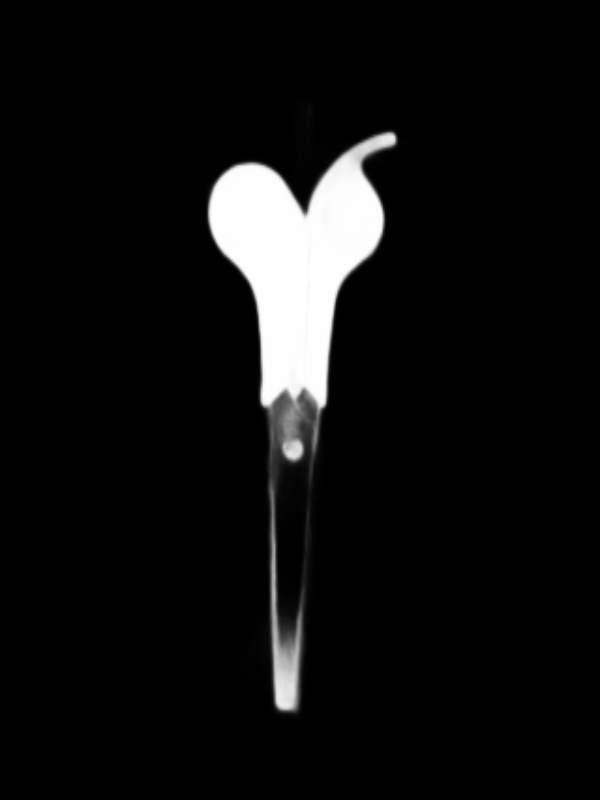

In [29]:
genImage(img_name_list[i_test],pred)

In [ ]:
# original
import cv2 as cv
from google.colab.patches import cv2_imshow
img = cv.imread(cv.samples.findFile("./sailboat3.jpg"))
cv2_imshow(img)